# loan optimization project, kaggel competition 

source: https://www.kaggle.com/kittiyaneerungon/loan-default-prediction
        

In [1]:
#importing the libraries

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [11]:
# Import dataset
df = pd.read_csv("data file/train_v2.csv.zip")
df.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f770,f771,f772,f773,f774,f775,f776,f777,f778,loss
0,1,126,10,0.686842,1100,3,13699,7201.0,4949.0,126.75,...,5,2.14,-1.54,1.18,0.1833,0.7873,1,0,5,0
1,2,121,10,0.782776,1100,3,84645,240.0,1625.0,123.52,...,6,0.54,-0.24,0.13,0.1926,-0.6787,1,0,5,0
2,3,126,10,0.500080,1100,3,83607,1800.0,1527.0,127.76,...,13,2.89,-1.73,1.04,0.2521,0.7258,1,0,5,0
3,4,134,10,0.439874,1100,3,82642,7542.0,1730.0,132.94,...,4,1.29,-0.89,0.66,0.2498,0.7119,1,0,5,0
4,5,109,9,0.502749,2900,4,79124,89.0,491.0,122.72,...,26,6.11,-3.82,2.51,0.2282,-0.5399,0,0,5,0


In [12]:
df.shape

(105471, 771)

In [13]:
# Check duplication in dataframe
df[df.duplicated()].shape

(0, 771)

In [14]:
# The number of each data type in the dataframe
df.dtypes.value_counts()

float64    653
int64       99
object      19
dtype: int64

In [15]:
df.columns

Index(['id', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9',
       ...
       'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778',
       'loss'],
      dtype='object', length=771)

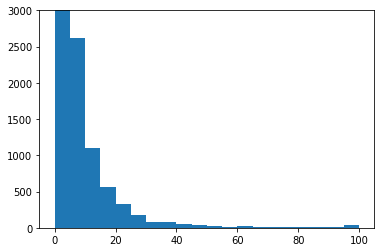

In [16]:
# Loss Distribution
fig , ax = plt.subplots()
plt.hist(df['loss'], bins = 20, range=(0,100))
ax.set_ylim([0,3000])
plt.show()

### Handling with Missing Value

In [17]:
# Calculate percent of missing in each row
df['num_missing'] = df.isnull().sum(axis = 1)/df.shape[1]

# Drop row that percent of missing more than 20%
missing_row = df[df['num_missing'] > 0.20].index
df.drop(df.index[missing_row], inplace = True)
df.shape

(105362, 772)

In [18]:
# Drop id and num_missing collumn
df.drop(columns = ['id','num_missing'], inplace = True)

In [19]:
# Calculate percent of missing in each column
col_pct_miss = []
for col in df.columns:
    percent_miss = np.mean(df[col].isnull())*100
    if percent_miss > 0:
        col_pct_miss.append([col, percent_miss])
    
col_pct_miss_df = pd.DataFrame(col_pct_miss, columns = ['column_name','% of Missing']).sort_values(by = '% of Missing', ascending = False)
col_pct_miss_df

,column_name,% of Missing
464,f663,17.823314
463,f662,17.823314
127,f159,17.693286
128,f160,17.693286
424,f619,17.418044
...,...,...
500,f720,0.000949
501,f721,0.000949
16,f41,0.000949
474,f675,0.000949


In [20]:
# Impute missing value in numeric columns with median 
numeric_cols = df.select_dtypes(include=['number']).columns.values

for col in numeric_cols:
    if col in list(col_pct_miss_df.column_name) :
        med = df[col].median()
        df[col] = df[col].fillna(med)

In [21]:
# Impute missing value in categorical columns with mode
not_numeric_cols = df.select_dtypes(exclude=['number']).columns.values

for col in not_numeric_cols:
    if col in list(col_pct_miss_df.column_name):
        mode = df[col].mode()[0]
        df[col] = df[col].fillna(mode)

In [22]:
# Check missing value
df.isnull().sum().value_counts()

0    770
dtype: int64

### Drop Unnecessary Columns

In [ ]:
# Drop Highly Corelated Columns

# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

df.drop(columns = to_drop, inplace = True)

In [ ]:
#Drop Repetitive Columns
num_rows = df.shape[0]
rep_cols = []

for col in df.loc[:, df.columns != 'loss'].columns :
    cnts = df[col].value_counts()
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.80:
        rep_cols.append([col,top_pct])
        
rep_col_df = pd.DataFrame(rep_cols, columns = ['column_name','% top repetitve value']).sort_values(by = '% top repetitve value', ascending = False).reset_index(drop=True)
rep_col_df

df.shape